In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [61]:
### constants
LABELS = ['Normal', 'Fraud']
RANDOM_SEED = 105
UPDATE_SIZE = 0.3
TEST_SIZE = 0.2
DATASET_PATH = Path('../creditcard.csv')

In [62]:
### data reading
df = pd.read_csv(DATASET_PATH)

In [63]:
### data preparing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


### преобразуем данные, убираем колонку "время", т.к. она ни на что не влияет
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

X_train, X_test = train_test_split(data, test_size=UPDATE_SIZE, random_state=RANDOM_SEED, stratify=Y)

X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

Y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [64]:
### количество мошенничеств в тестовых данных
sum(Y_test)

148

In [98]:
### Creating model
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import metrics


input_dim = X_train.shape[1]
encoding_dim = 14

In [99]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [100]:
nb_epoch = 40
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.h5',
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 199020 samples, validate on 85443 samples
Epoch 1/40
199020/199020 [==============================] - 9s 46us/step - loss: 0.8403 - accuracy: 0.5621 - val_loss: 0.8365 - val_accuracy: 0.6096
Epoch 2/40
199020/199020 [==============================] - 9s 45us/step - loss: 0.7756 - accuracy: 0.6331 - val_loss: 0.8133 - val_accuracy: 0.6409
Epoch 3/40
199020/199020 [==============================] - 9s 45us/step - loss: 0.7647 - accuracy: 0.6494 - val_loss: 0.8066 - val_accuracy: 0.6531
Epoch 4/40
199020/199020 [==============================] - 10s 51us/step - loss: 0.7597 - accuracy: 0.6588 - val_loss: 0.8038 - val_accuracy: 0.6651
Epoch 5/40
199020/199020 [==============================] - 8s 40us/step - loss: 0.7553 - accuracy: 0.6640 - val_loss: 0.7997 - val_accuracy: 0.6631
Epoch 6/40
199020/199020 [==============================] - 8s 42us/step - loss: 0.7520 - accuracy: 0.6682 - val_loss: 0.7972 - val_accuracy: 0.6709
Epoch 7/40
199020/199020 [============================

In [101]:
model = load_model('model.h5')

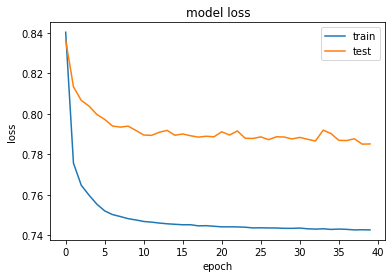

In [102]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [103]:
predictions = autoencoder.predict(X_test)

In [104]:
import numpy as np


mse = np.mean(np.power(X_test - predictions, 2), axis=1)

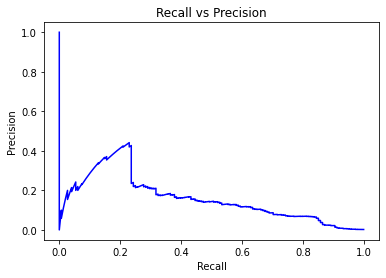

In [107]:
from sklearn.metrics import precision_recall_curve


precision, recall, th = precision_recall_curve(Y_test, mse)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
plt.savefig('fname.svg', dpi=300, facecolor='w', edgecolor='red',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1)